In [1]:
import sys
from pathlib import Path
sys.path.append(str(Path().absolute().parent))

In [2]:
import ee 
import geemap

ee.Initialize(project="thurgau-irrigation")

*** Earth Engine *** Share your feedback by taking our Annual Developer Satisfaction Survey: https://google.qualtrics.com/jfe/form/SV_0JLhFqfSY1uiEaW?source=Init


In [3]:
from typing import Tuple
import matplotlib.pyplot as plt
import numpy as np

from src.et_blue_per_field.et_blue_field_postprocessing import compute_field_et_stats, compute_et_volume

from utils.ee_utils import (
    back_to_float,
    back_to_int,
    export_image_to_asset,
    print_value_ranges,
    is_image_empty,
    fill_gaps_with_zeros
)

from utils.date_utils import print_collection_dates, merge_same_date_images




---

In [4]:
YEAR = 2018

PATH_TO_ET_BLUE_POSTPROCESSED = f"projects/thurgau-irrigation/assets/FribourgAndVaud/ET_blue_postprocessed/ET_blue_postprocessed_{YEAR}_dekadal_from_WaPOR_10m"
PATH_TO_FIELD_BOUNDARIES = f"projects/thurgau-irrigation/assets/FribourgAndVaud/blind_potato_fields"

SCALING_FACTOR = 100

In [5]:
et_blue_postprocessed_collection = ee.ImageCollection(PATH_TO_ET_BLUE_POSTPROCESSED).map(lambda img: back_to_float(img, SCALING_FACTOR))

et_blue_postprocessed_collection.first().bandNames().getInfo()

et_blue_postprocessed_list = et_blue_postprocessed_collection.toList(et_blue_postprocessed_collection.size())

In [6]:
crop_fields = ee.FeatureCollection(PATH_TO_FIELD_BOUNDARIES)

In [7]:
image = ee.Image(et_blue_postprocessed_list.get(7))

fileds_with_stats = compute_field_et_stats(
    et_image=image,
    fields=crop_fields,
    et_band_name="ET_blue",
    scale=10,
)

In [8]:
fileds_with_stats.first().getInfo()

{'type': 'Feature',
 'geometry': {'type': 'Polygon',
  'coordinates': [[[6.898340787574285, 46.82566675554755],
    [6.898380968295865, 46.82564443232396],
    [6.8985682164940565, 46.8256488679297],
    [6.898871397517888, 46.82567117592232],
    [6.900851242980219, 46.828560704623655],
    [6.900837916119662, 46.828565147649975],
    [6.900360784718916, 46.82873013401383],
    [6.900307299635416, 46.82870782203597],
    [6.899303962420583, 46.82718283774913],
    [6.898345301063176, 46.825706872132194],
    [6.898340787574285, 46.82566675554755]]]},
 'id': '00000000000000000000',
 'properties': {'ID': '18-1-510429',
  'Jahr': 18,
  'Kultur': 'Kartoffeln',
  'mean_et_nonzero': 0.3496745406824148,
  'median_et_blue': 0,
  'std_dev_et_nonzero': 0.1323568626870021,
  'xkoord': 2558887.733,
  'ykoord': 1186364.763,
  'zero_fraction': 0.7540983606557373}}

In [9]:
Map = geemap.Map()

vis_params = {"bands": ["ET_blue"], "min": 0, "max": 1, "palette": "viridis"}


Map.addLayer(image, vis_params, "et_blue_postprocessed")
Map.addLayer(crop_fields, {"color": "green"}, "crop_fields")
Map.addLayer(fileds_with_stats, {"color": "red"}, "fields_with_stats")

Map.centerObject(crop_fields, 12)


Map

Map(center=[46.81340138134065, 6.909127982292969], controls=(WidgetControl(options=['position', 'transparent_b…

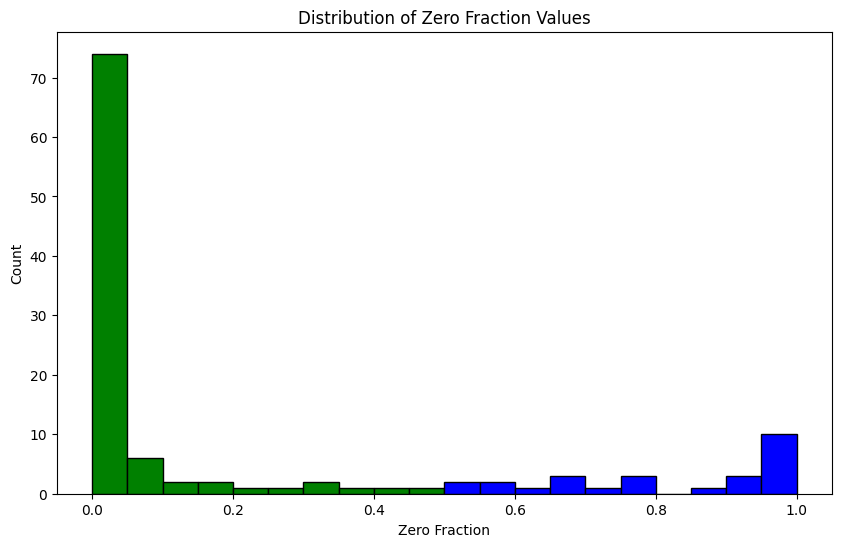

In [10]:
def plot_zero_fraction_distribution(fc: ee.FeatureCollection):
   props = fc.reduceColumns(ee.Reducer.toList(2), ['zero_fraction', 'median_et_blue']).get('list').getInfo()
   
   zero_fracs = [p[0] for p in props if p[0] is not None and p[1] is not None]
   et_blues = [p[1] for p in props if p[0] is not None and p[1] is not None]

   fig, ax = plt.subplots(figsize=(10, 6))
   n, bins, patches = ax.hist(zero_fracs, bins=20, edgecolor='black')
   
   # For each bin, check if median_et_blue is zero
   bin_colors = []
   for i in range(len(bins)-1):
       mask = (np.array(zero_fracs) >= bins[i]) & (np.array(zero_fracs) < bins[i+1])
       bin_et = np.mean(np.array(et_blues)[mask]) if any(mask) else 0
       bin_colors.append('blue' if bin_et == 0 else 'green')
   
   for patch, color in zip(patches, bin_colors):
       patch.set_facecolor(color)
   
   ax.set_xlabel('Zero Fraction')
   ax.set_ylabel('Count')
   ax.set_title('Distribution of Zero Fraction Values')
   
   return plt

fc = ee.FeatureCollection(fileds_with_stats)
plot = plot_zero_fraction_distribution(fc)
plot.show()



In [12]:
feature_with_m3 = compute_et_volume(fileds_with_stats)

feature_with_m3.first().getInfo()

Map.addLayer(feature_with_m3, {"color": "blue"}, "fields_with_volume")